In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import linregress
from statsmodels.tsa.arima.model import ARIMA
from pyts.decomposition import SingularSpectrumAnalysis
from pmdarima.arima import auto_arima
import warnings
import itertools
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
import rpy2.robjects as ro
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import pywt
from sklearn.decomposition import PCA
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.utils.extmath import randomized_svd
from PyEMD import EMD
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis
from pykalman import KalmanFilter
import torch
import torch.nn as nn
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from astropy.timeseries import LombScargle
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import requests
import pandas as pd
from io import StringIO

# Подавляем только FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

/home/saatarko/anaconda3/envs/myenv/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1185: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/local/cuda-12.1/lib64:", R: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.1/lib64:"
  warnings.warn(
/home/saatarko/anaconda3/envs/myenv/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1185: UserWarning: Environment variable "PWD" redefined by R and overriding existing variable. Current: "/home/saatarko/PycharmProjects/time_series", R: "/home/saatarko/PycharmProjects/time_series/notebooks"
  warnings.warn(
/home/saatarko/anaconda3/envs/myenv/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1185: UserWarning: Environment variable "LD_LIBRARY_PATH" redefined by R and overriding existing variable. Current: "/usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/default-java/lib/server:/usr/local/cuda-12.1/lib64

In [4]:
data = sm.datasets.get_rdataset("AirPassengers").data
data

,time,value
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121
...,...,...
139,1960.583333,606
140,1960.666667,508
141,1960.750000,461
142,1960.833333,390


In [7]:
# Функция для перевода дробного года в дату (приблизительно)
def fractional_year_to_datetime(fyear):
    year = int(fyear)
    remainder = fyear - year
    month = int(remainder * 12) + 1
    return pd.Timestamp(year=year, month=month, day=1)

dates = data['time'].apply(fractional_year_to_datetime)
time_series.index = dates

In [8]:
time_series

time
1949-01-01    112
1949-01-01    118
1949-03-01    132
1949-04-01    129
1949-04-01    121
             ... 
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: value, Length: 144, dtype: int64

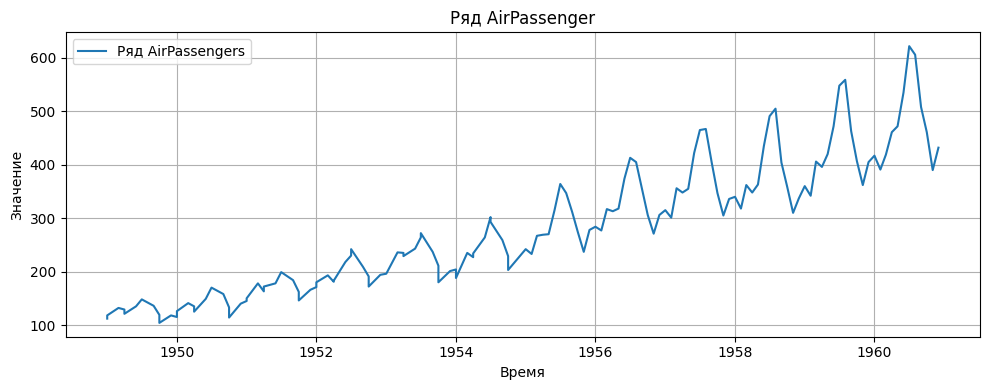

In [10]:
# Построение графика
plt.figure(figsize=(10, 4))
plt.plot(time_series, label="Ряд AirPassengers")
plt.title("Ряд AirPassenger")
plt.xlabel("Время")
plt.ylabel("Значение")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Визуально виден тенд и веротяно сезонность. Проверим ряд на статичность

In [11]:
result = adfuller(time_series)
print(f'p-value: {result[1]}')

p-value: 0.9918802434376413


**p-value сильно больше 0.05 следовательно ряд нестатичный**

ПО шумам непонятно. Попробуем сделать EMD

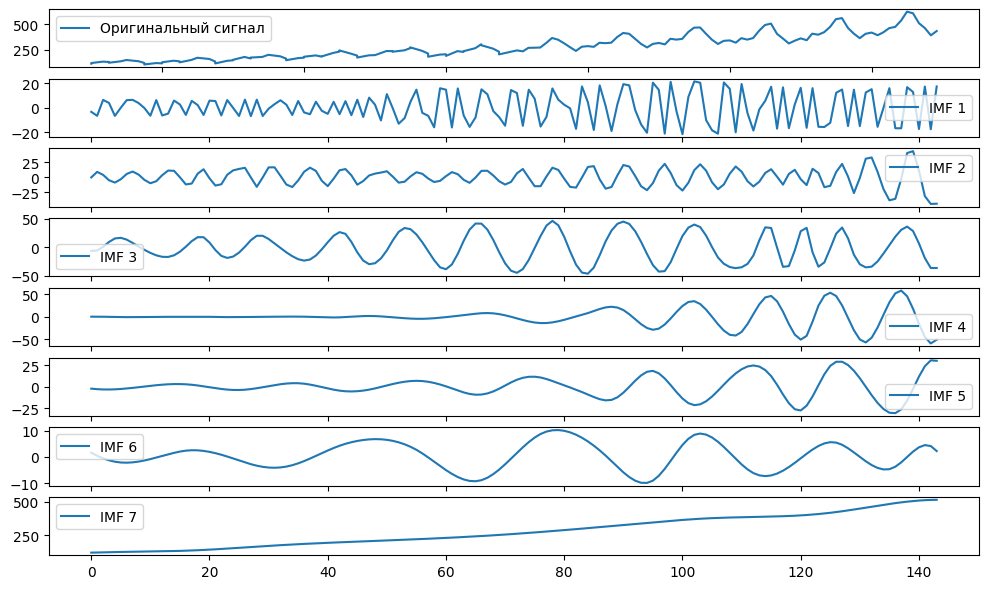

In [12]:
emd = EMD()
imfs = emd(time_series)

# Визуализация
plt.figure(figsize=(12, 8))
plt.subplot(len(imfs)+2, 1, 1)
plt.plot(time_series, label='Оригинальный сигнал')
plt.legend()

# Все IMFs
for i, imf in enumerate(imfs):
    plt.subplot(len(imfs)+2, 1, i+2)
    plt.plot(imf, label=f'IMF {i+1}')
    plt.legend()


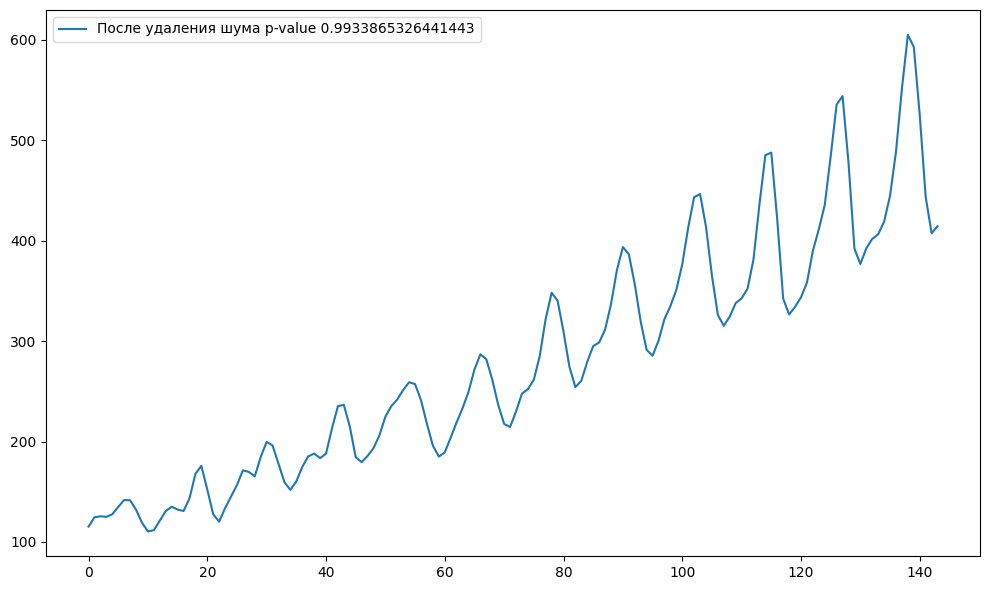

In [15]:

# Восстановленный сигнал без первых IMF (например, IMF1 — шум)
denoised = np.sum(imfs[1:], axis=0)
EMDval = adfuller(denoised)[1]

plt.figure(figsize=(10, 6))
plt.plot(denoised, label=f'После удаления шума p-value {EMDval}')
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
time_series_denoised = pd.Series(denoised)
time_series_denoised

0      115.239397
1      124.492146
2      125.504094
3      124.952239
4      127.520094
          ...    
139    593.091782
140    525.243749
141    443.638688
142    407.431127
143    414.545990
Length: 144, dtype: float64

Попробуем удалить тернд из данных. ПОпробуем дифференцирование, темпы роста и скользующую среднюю

In [26]:
diff_series = time_series_denoised.diff().dropna()
diff_result = adfuller(diff_series)
print(f'p-value: {diff_result[1]}')

p-value: 0.055107219823888255


**p-value чуть чуть выше 0.05 следовательно ряд еще нестатичный, но мы еще не удаляли сезонность**

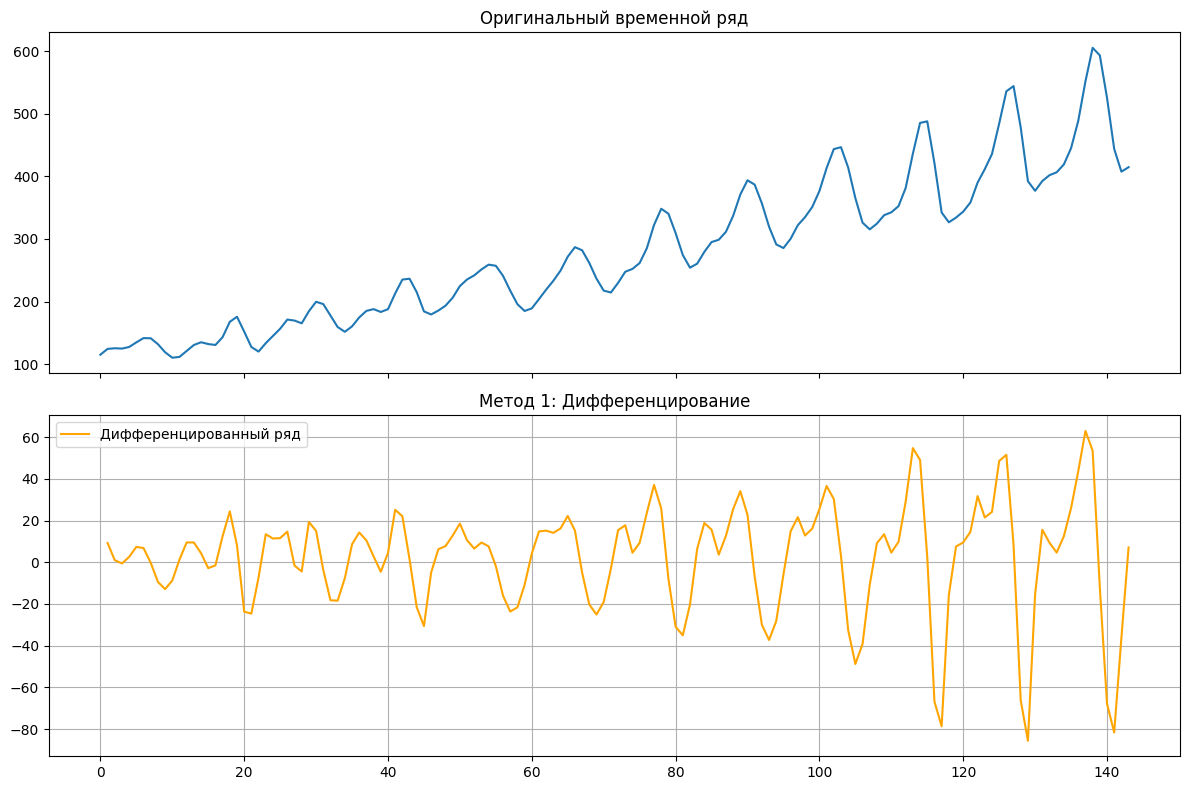

In [27]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_series_denoised, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[1].plot(diff_series, color='orange', label="Дифференцированный ряд")
axs[1].set_title("Метод 1: Дифференцирование")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Тоже самое но через темпы роста

In [29]:
pct_growth = time_series_denoised.pct_change().dropna()

pct_growth_result = adfuller(pct_growth)
print(f'p-value: {pct_growth_result[1]}')

p-value: 0.04344525158887622


**p-value чуть чуть ниже 0.05 следовательно ряд уже статичный, но мы еще не удаляли сезонность**

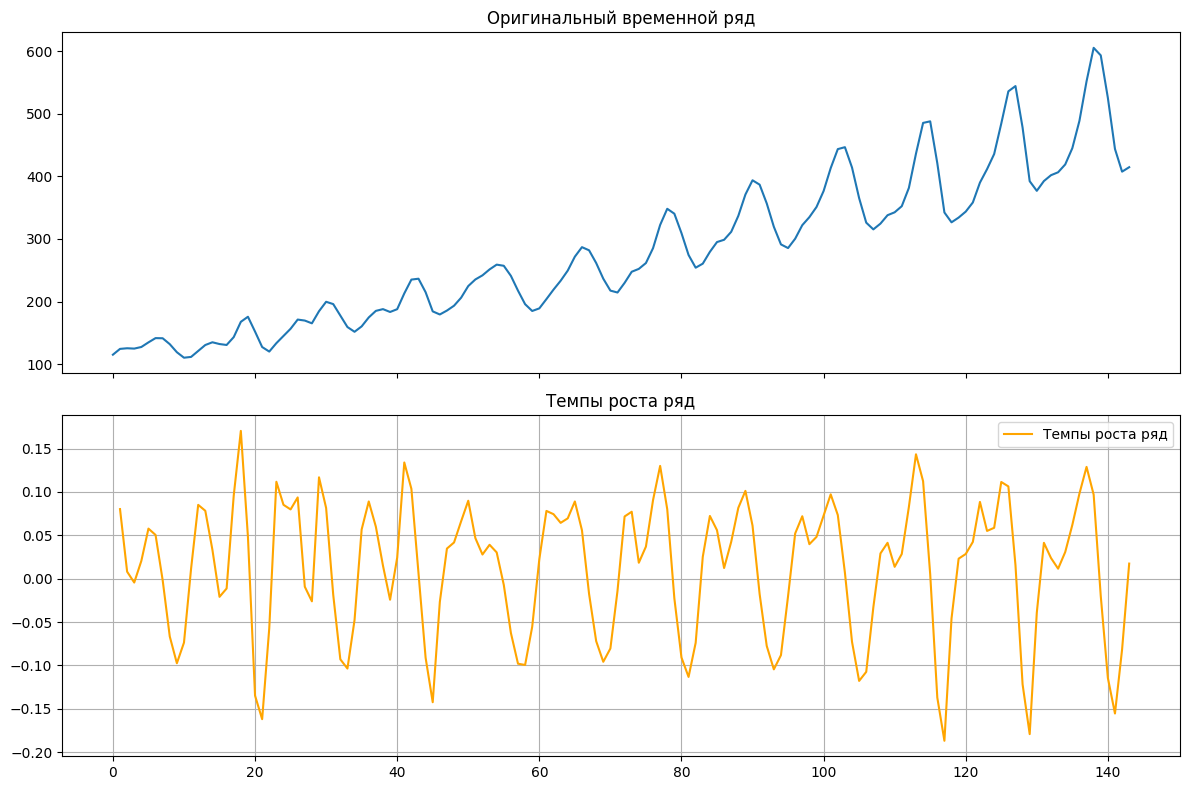

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axs[0].plot(time_series_denoised, label="Оригинальный ряд")
axs[0].set_title("Оригинальный временной ряд")
axs[1].plot(pct_growth, color='orange', label="Темпы роста ряд")
axs[1].set_title("Темпы роста ряд")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Теперь попробуем скользящее среднее

In [34]:
for w in [6, 8, 12, 14, 16, 18, 24, 32]:
    rolling_mean = time_series_denoised.rolling(window=w).mean()
    # rolling_mean сдвинут назад на (w-1), поэтому подрежем time_series_denoised
    detrended = time_series_denoised[w-1:] - rolling_mean[w-1:]
    detrended = detrended.dropna()
    pvalue = adfuller(detrended)[1]
    print(f"Window={w}: ADF p-value = {pvalue:.4f}")


Window=6: ADF p-value = 0.1703
Window=8: ADF p-value = 0.0874
Window=12: ADF p-value = 0.0727
Window=14: ADF p-value = 0.0989
Window=16: ADF p-value = 0.1116
Window=18: ADF p-value = 0.1776
Window=24: ADF p-value = 0.2567
Window=32: ADF p-value = 0.4132


ADF p-value (rolling mean): 0.07269


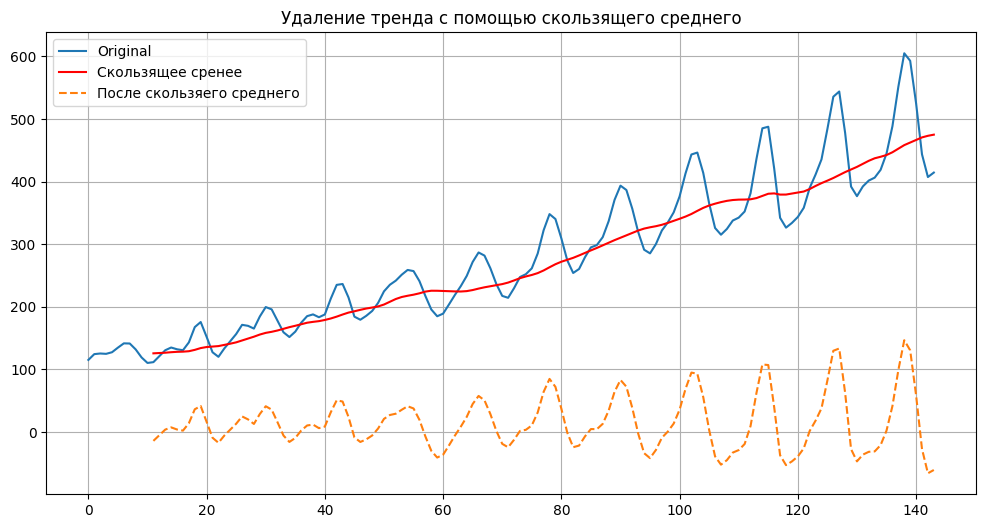

In [41]:
w = 12  # наименьшее значение
rolling_mean = time_series_denoised.rolling(window=w).mean()

# Вычитаем скользящее среднее → устраняем тренд
detrended = time_series_denoised[w-1:] - rolling_mean[w-1:]
detrended_rolling = detrended.dropna()

adf_result_roll = adfuller(detrended_rolling)
print(f"ADF p-value (rolling mean): {adf_result_roll[1]:.5f}")

# Визуализация

plt.figure(figsize=(12, 6))
plt.plot(time_series_denoised, label="Original")
plt.plot(rolling_mean, label="Скользящее сренее", color="red")
plt.plot(detrended_rolling, label="После скользяего среднего", linestyle="--")
plt.legend()
plt.title("Удаление тренда с помощью скользящего среднего")
plt.grid(True)
plt.show()

### Вывод метод темпов роста показал себя лучше всего т.е немного улучшил дисперсию что положительно сиграло на статичности ряда. Будем использовать данные посе темпов роста

In [43]:
time_series_denoised_detrended = pct_growth

## Теперь попробуем вычислить периодичность сезонности

<Figure size 1000x400 with 0 Axes>

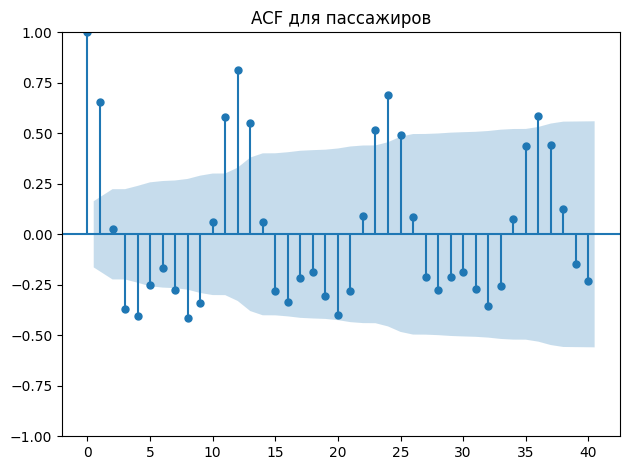

In [44]:
plt.figure(figsize=(10, 4))
plot_acf(time_series_denoised_detrended, lags=40)
plt.title("ACF для пассажиров")
plt.tight_layout()
plt.show()


Судя по всему 12 (что логично годичный цикл) но проверим остальными методами.

In [45]:
freqs, psd = periodogram(time_series_denoised_detrended)
dominant_freq_index = np.argmax(psd[1:]) + 1  # пропускаем нулевую частоту
dominant_freq = freqs[dominant_freq_index]
seasonal_period = int(round(1 / dominant_freq))

seasonal_period

12

In [48]:
time_series_denoised_detrended

1      0.080292
2      0.008129
3     -0.004397
4      0.020551
5      0.057788
         ...   
139   -0.019893
140   -0.114397
141   -0.155366
142   -0.081615
143    0.017463
Length: 143, dtype: float64

In [50]:
# time_series — pandas.Series с datetime индексом и значениями y
# Преобразуем индекс в числовой формат, например, в количество дней от начала:
y = time_series_denoised_detrended.values
t = np.arange(1, len(y) + 1)  # т.к. индекс начинается с 1

min_freq = 1/50  # например, максимум период 50 шагов
max_freq = 1/2   # минимум период 2 шага (Nyquist)
frequency, power = LombScargle(t, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
best_freq = frequency[np.argmax(power)]
best_period = 1 / best_freq
print(f"Best frequency: {best_freq:.4f}")
print(f"Best period: {best_period:.2f}")

Best frequency: 0.0834
Best period: 11.99


### Везде получили 12 (или ококло того)

ПОпробуем тутже удалить сезонность через  LombScargle

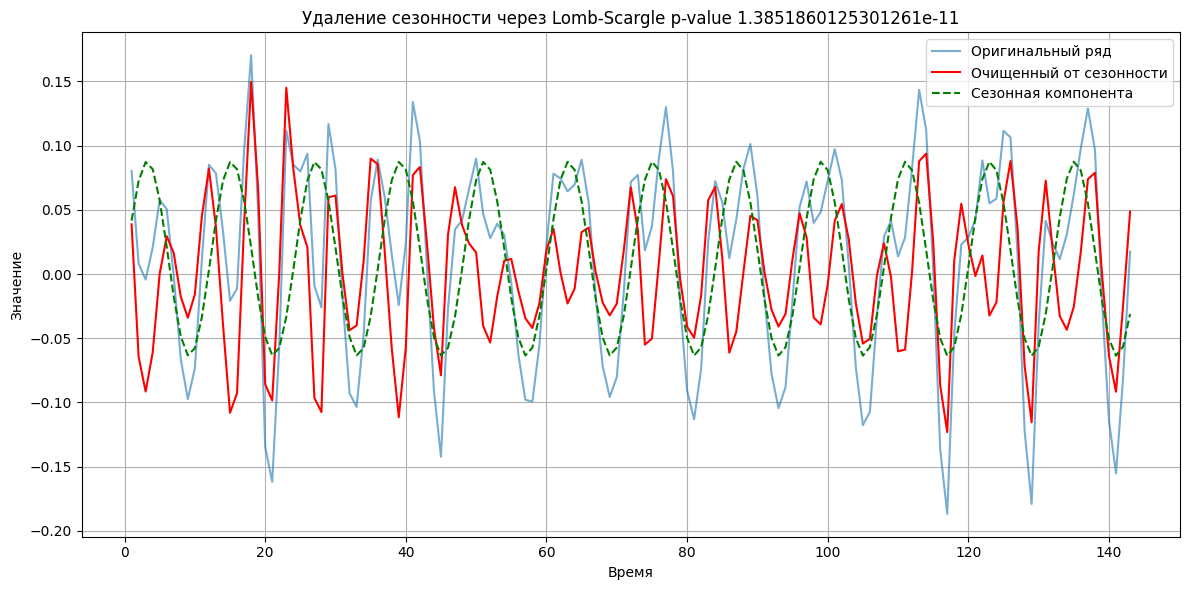

In [52]:
seasonal_component = LombScargle(t, y).model(t, best_freq)

# 4. Вычитаем сезонную компоненту → очищенный ряд
deseasoned = y - seasonal_component

lomb_result = adfuller(deseasoned)


# 5. Визуализация
plt.figure(figsize=(12, 6))
plt.plot(t, y, label='Оригинальный ряд', alpha=0.6)
plt.plot(t, deseasoned, label='Очищенный от сезонности', color='red')
plt.plot(t, seasonal_component, label='Сезонная компонента', linestyle='--', color='green')
plt.title(f'Удаление сезонности через Lomb-Scargle p-value {lomb_result[1]}')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Попробуем отдельно почистить сезонность "Сезонным дифференцированием"(seasonal differencing)

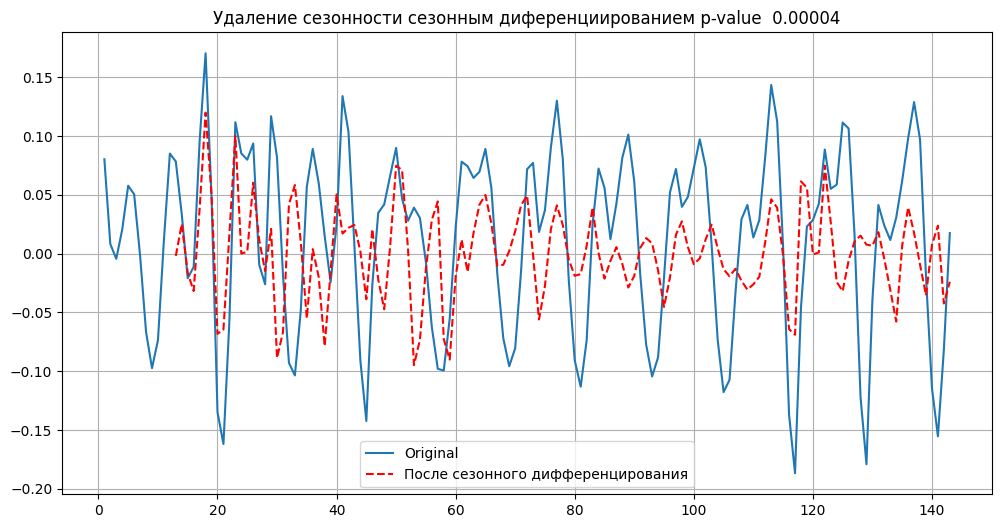

In [54]:
seasonal_diff = time_series_denoised_detrended.diff(12)
season_diff_result = adfuller(seasonal_diff.dropna())

plt.figure(figsize=(12, 6))
plt.plot(time_series_denoised_detrended, label="Original")
plt.plot(seasonal_diff, label="После сезонного дифференцирования", color="red", linestyle="--")
plt.legend()
plt.title(f"Удаление сезонности сезонным диференциированием p-value  {season_diff_result[1]:.5f}")
plt.grid(True)
plt.show()

In [55]:
if season_diff_result < lomb_result:
    print('Сезонная сработала круче')
else:
    print('LombScargle сработал лучше')


LombScargle сработал лучше


In [58]:
result_series = pd.Series(deseasoned)

In [74]:
# result_series — pd.Series очищенного ряда
df = pd.DataFrame({'y': result_series})

# Создаем лаги, например, 3 предыдущих шага
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['y'].shift(lag)

df = df.dropna()

X = df.drop('y', axis=1)
y = df['y']

# Делим на train/test, например 80/20
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Предсказания на тесте
y_pred_rf = model_rf.predict(X_test)

In [63]:
stepwise_model = auto_arima(result_series,
                            start_p=0, start_q=0,
                            max_p=5, max_q=5,
                            seasonal=False,
                            d=None,            # автоопределение порядка дифференцирования
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-424.790, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-454.818, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-521.357, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-527.328, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-613.279, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-613.875, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-612.421, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-611.736, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-611.927, Time=0.07 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 0.459 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  143
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 309.938
Date:                Чцв, 05 чэр 2025   AIC      

In [64]:
# Обучаем ARIMA на train-части
train_arima = result_series.iloc[:train_size]
test_arima = result_series.iloc[train_size:]

model_arima = ARIMA(train_arima, order=(2,0,0))  # p,d,q 
model_arima_fit = model_arima.fit()

# Предсказание для теста (экзогенные данные не нужны)
y_pred_arima = model_arima_fit.forecast(steps=len(test_arima))

In [65]:
stepwise_model = auto_arima(time_series,
                            start_p=0, start_q=0,
                            max_p=5, max_q=5,
                            seasonal=False,
                            d=None,            # автоопределение порядка дифференцирования
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1415.278, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1403.473, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1398.827, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1413.909, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1396.121, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1398.386, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1397.975, Time=0.04 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1394.683, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1397.258, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1401.852, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1378.338, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1396.5

In [66]:
initial_series = time_series

train_init = initial_series.iloc[:train_size]
test_init = initial_series.iloc[train_size:]

model_arima_init = ARIMA(train_init, order=(4,1,3))
model_arima_init_fit = model_arima_init.fit()

y_pred_arima_init = model_arima_init_fit.forecast(steps=len(test_init))

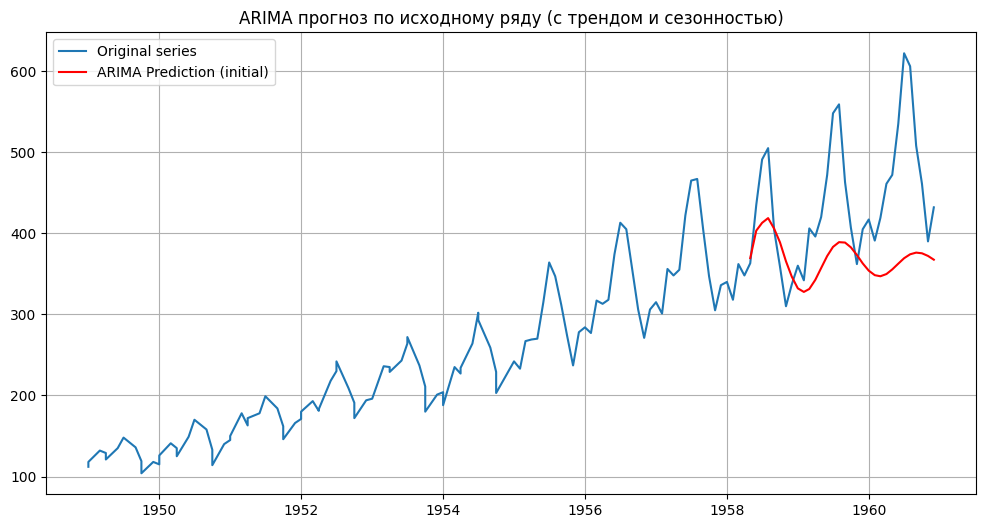

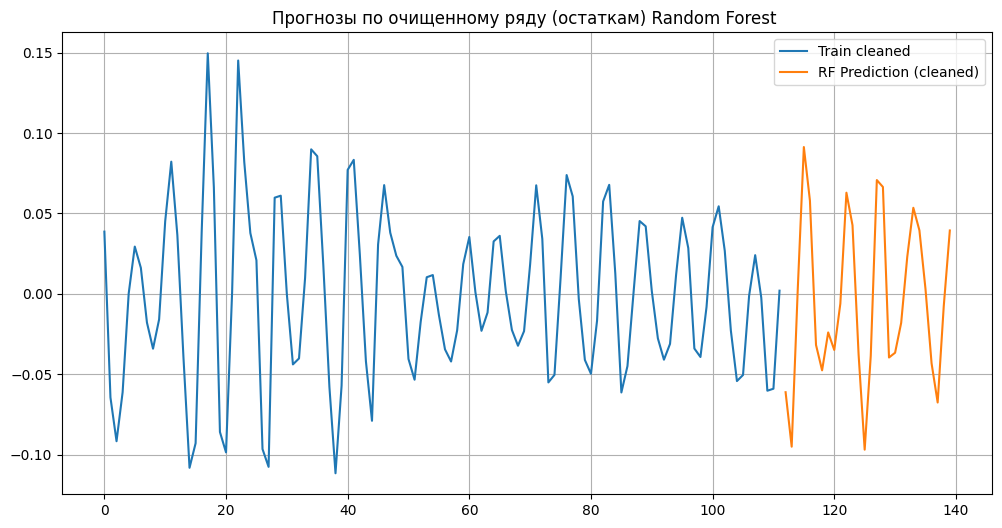

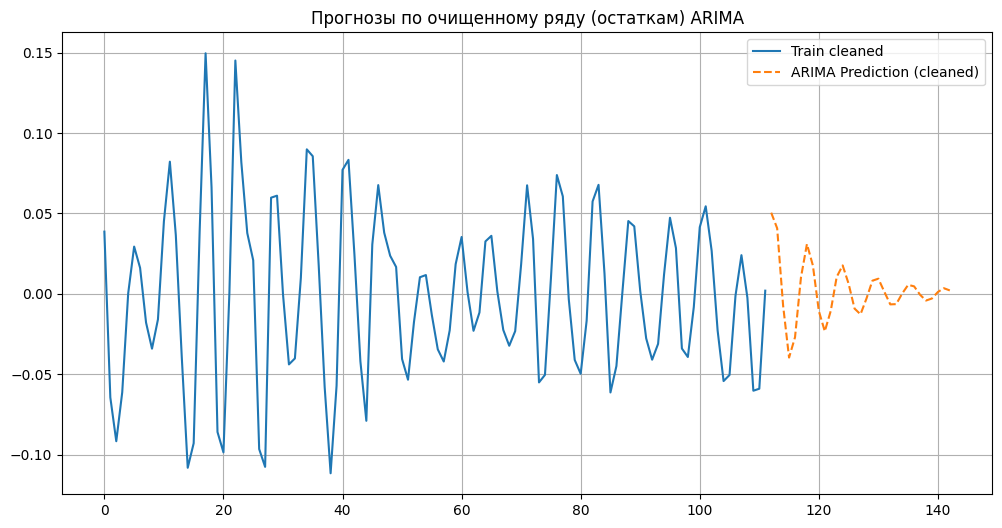

In [72]:
# --- 1. График ARIMA на исходном ряде ---
plt.figure(figsize=(12, 6))
plt.plot(initial_series.index, initial_series, label='Original series')
plt.plot(initial_series.index[train_size:], y_pred_arima_init, label='ARIMA Prediction (initial)', color='red')
plt.title('ARIMA прогноз по исходному ряду (с трендом и сезонностью)')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. График прогнозов на очищенном ряде ---
plt.figure(figsize=(12, 6))
plt.plot(result_series.index[:train_size], result_series.iloc[:train_size], label='Train cleaned')
plt.plot(result_series.index[train_size:train_size+len(y_pred_rf)], y_pred_rf, label='RF Prediction (cleaned)')
plt.title('Прогнозы по очищенному ряду (остаткам) Random Forest ')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. График прогнозов на очищенном ряде ---
plt.figure(figsize=(12, 6))
plt.plot(result_series.index[:train_size], result_series.iloc[:train_size], label='Train cleaned')
plt.plot(result_series.index[train_size:train_size+len(y_pred_arima)], y_pred_arima, label='ARIMA Prediction (cleaned)', linestyle='--')
plt.title('Прогнозы по очищенному ряду (остаткам) ARIMA')
plt.legend()
plt.grid(True)
plt.show()




| Модель             | Прогноз визуально  | Прогноз в числах    | Применимость         |
| ------------------ | ------------------ | ------------------- | -------------------- |
| RF на остатках     | Наиболее точный    | Может переобучиться | Краткосрочные задачи |
| ARIMA на остатках  | Гаснущие колебания | Слишком гладко      | Не хватает паттерна  |
| ARIMA на оригинале | Сильно сглажен     | Стабильно           | Долгосрочный прогноз |


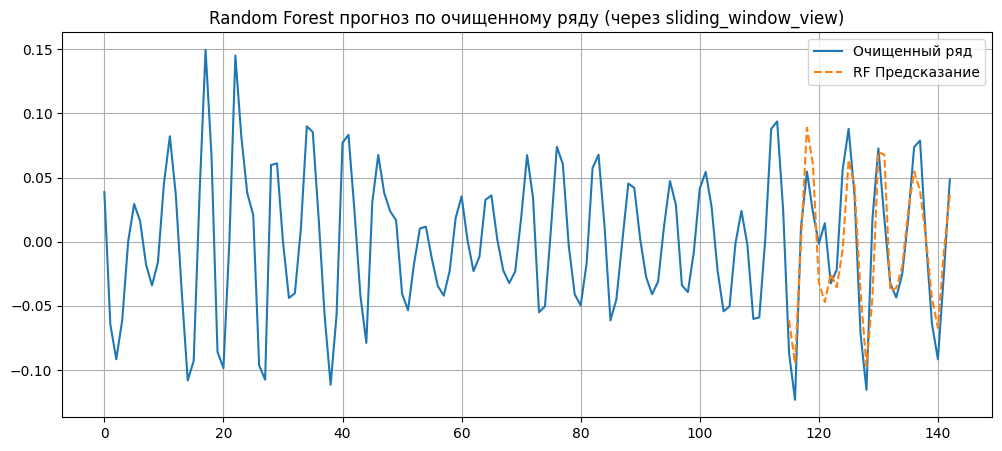

In [75]:
# result_series — очищенный стационарный ряд (pd.Series)
window_size = 4  # 3 лага + 1 таргет → как в lag_1 ... lag_3

# Преобразуем в NumPy и создаем окна
X_window = sliding_window_view(result_series.values, window_shape=window_size)

# Отделяем X (3 лага) и y (целевое значение)
X = X_window[:, :-1]
y = X_window[:, -1]

# Восстановим правильные индексы для y
target_index = result_series.index[window_size - 1:]

# Делим на train/test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
index_test = target_index[train_size:]  # индекс для отображения предсказаний

# Обучаем модель
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Предсказываем
y_pred_rf = model_rf.predict(X_test)

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(result_series.index, result_series.values, label='Очищенный ряд')
plt.plot(index_test, y_pred_rf, label='RF Предсказание', linestyle='--')
plt.legend()
plt.title('Random Forest прогноз по очищенному ряду (через sliding_window_view)')
plt.grid()
plt.show()

In [76]:
stat, p_value, lags, crit = kpss(result_series, regression='c')
print(f'KPSS Statistic: {stat}, p-value: {p_value}')

KPSS Statistic: 0.10934176783144628, p-value: 0.1


In [7]:
import requests
import pandas as pd
from io import StringIO
import json

url = "https://api.alternative.me/fng/?limit=0&format=json&date_format=world"

response = requests.get(url)
data = response.json()  # распарсим сразу в словарь Python

# data['data'] - список словарей с данными по каждому дню
fng_df = pd.DataFrame(data['data'])

# Конвертируем 'timestamp' в datetime с форматом день-месяц-год
fng_df['date'] = pd.to_datetime(fng_df['timestamp'], format='%d-%m-%Y')

# Приведём значение индекса страха/жадности к числовому типу
fng_df['value'] = fng_df['value'].astype(int)

# Отфильтруем только нужные колонки для анализа
fng_df = fng_df[['date', 'value', 'value_classification']]

print(fng_df.head())


        date  value value_classification
0 2025-06-07     52              Neutral
1 2025-06-06     45                 Fear
2 2025-06-05     57                Greed
3 2025-06-04     62                Greed
4 2025-06-03     64                Greed


In [9]:
fng_df.to_csv('Greed.csv', index=False)

In [ ]:
freqs, power = periodogram(cycle_component)
dominant_freq_index = np.argmax(power[1:]) + 1  # пропускаем нулевую частоту
dominant_freq = freqs[dominant_freq_index]
seasonal_period = int(round(1 / dominant_freq))

seasonal_period

In [ ]:
y = cycle_component
t = np.arange(1, len(y) + 1)  # т.к. индекс начинается с 1

min_freq = 1/100  # например, максимум период 100 шагов
max_freq = 1/2   # минимум период 2 шага (Nyquist)
frequency, power = LombScargle(t, y).autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
best_freq = frequency[np.argmax(power)]
best_period = 1 / best_freq
print(f"Best frequency: {best_freq:.4f}")
print(f"Best period: {best_period:.2f}")